In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob

# Function to load image and mask

In [2]:
image_files = []
mask_files = glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_files.append(i.replace('_mask',''))

In [3]:
def load_image(path):
    image=cv2.imread(path)
    image=cv2.resize(image,(256,256))
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB) 
    image = np.expand_dims(image, axis=0)
    return image/255.0

def load_label(path):
    image=cv2.imread(path)
    image=cv2.resize(image,(256,256))
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = image.astype(np.float32)
    return np.expand_dims(image/255.0,axis=-1)

# Data Visualization

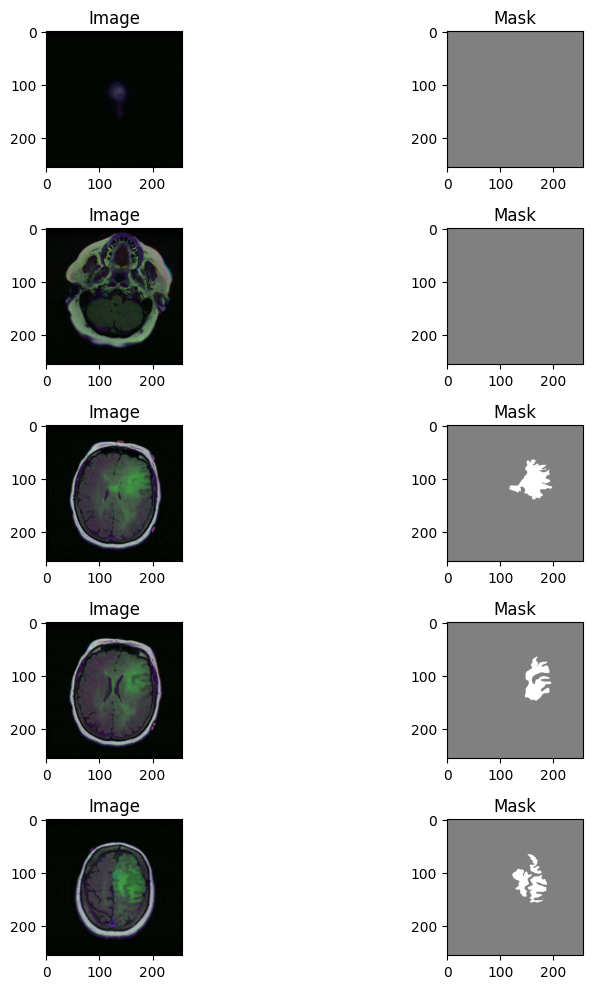

In [4]:
# Let's plot some samples
rows, cols = 5, 2
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i in range(rows):
    img_path = image_files[i]
    msk_path = mask_files[i]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    msk = cv2.imread(msk_path)
    
    axes[i, 0].imshow(img)
    axes[i, 1].imshow(msk, alpha=0.5)

    axes[i, 0].set_title('Image')
    axes[i, 1].set_title('Mask')

plt.tight_layout()
plt.show()


# Create contour mask according to data format for YOLO model

In [5]:
def mask_to_yolo_contours(mask, annotation_file):
    mask = mask.replace('.tif', '_mask.tif')
#     print(mask)
    open(annotation_file, "w").close()
    binary_mask = load_label(mask)
    
    binary_mask = binary_mask.reshape(256, 256)
    binary_mask = binary_mask.astype(np.uint8)
    
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     print(contours)
    for cnt in contours:
        st = '0 '
        for i in cnt:
            st += str(i[0][0]/256) + ' ' + str(i[0][1]/256) + ' '
        with open(annotation_file, 'a') as ann_file:
            ann_file.write(st + '\n')

# Create train, valid, test image folders in YOLO format

In [6]:
IMAGES = "images/"
LABELS = "labels/"
os.makedirs(IMAGES+"train", exist_ok=True)
os.makedirs(LABELS+"train", exist_ok=True)
os.makedirs(IMAGES+"valid", exist_ok=True)
os.makedirs(LABELS+"valid", exist_ok=True)
os.makedirs(IMAGES+"test", exist_ok=True)
os.makedirs(LABELS+"test", exist_ok=True)

In [7]:
df = pd.DataFrame(data={"image_path": image_files, 'mask_path' : mask_files})
df.head()

image_path  \
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                           mask_path  
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

# Create dataframe and divide data into train, validation, and test sets

In [8]:
from sklearn.model_selection import train_test_split

df_train, df_valid_test = train_test_split(df,test_size=0.2,random_state=42)
df_valid, df_test = train_test_split(df_valid_test,test_size=0.5,random_state=42)

files = list(df.image_path.unique())
files_train,files_valid_test = train_test_split(files,test_size=0.2,random_state=42)
files_valid,files_test = train_test_split(files_valid_test,test_size=0.5,random_state=42)

len(files_train),len(files_valid), len(files_test)

(3143, 393, 393)

# Copy the image file into the YOLO format folder

In [9]:
import shutil

train_filename = set(files_train)
valid_filename = set(files_valid)
test_filename = set(files_test)
for i,file in enumerate(files):
    if file in train_filename:
        shutil.copy(file, IMAGES+"train")
        name = file.split("/")[6]
        anno_file = os.path.join(LABELS) + "train/"+name.replace('.tif', '.txt')
        mask_to_yolo_contours(file, anno_file)
        
    elif file in valid_filename:
        shutil.copy(file, IMAGES+"valid")
        name = file.split("/")[6]
        anno_file = os.path.join(LABELS) + "valid/"+name.replace('.tif', '.txt')
        mask_to_yolo_contours(file, anno_file)
            
    elif file in test_filename:
        shutil.copy(file, IMAGES+"test")
        name = file.split("/")[6]
        anno_file = os.path.join(LABELS) + "test/"+name.replace('.tif', '.txt')
        mask_to_yolo_contours(file, anno_file)

# Create dataset config file for YOLO

In [10]:
%%writefile dataset.yaml
# Path
train: /kaggle/working/images/train
val: /kaggle/working/images/valid

# Classes
nc: 1
names: ['Tumor']

Writing dataset.yaml


# Install YOLO

In [11]:
!pip install -U ultralytics
!pip install -U ipywidgets
!pip install -U ray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 572.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.8/778.8 kB 5.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.2 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 3.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ip

# Load the YOLOv9 model and train

In [12]:
from ultralytics import YOLO

model = YOLO('yolov9e-seg.pt')

train = model.train(data="/kaggle/working/dataset.yaml", epochs=50, batch=32, lr0=0.000001, imgsz=256)

100%|██████████| 117M/117M [00:00<00:00, 266MB/s]  


Ultralytics YOLOv8.2.25 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov9e-seg.pt, data=/kaggle/working/dataset.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

100%|██████████| 755k/755k [00:00<00:00, 13.8MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1         0  ultralytics.nn.modules.block.Silence         []                            
  1                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  2                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  3                  -1  1    252160  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 2]        
  4                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  5                  -1  1   1004032  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 2]       
  6                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  7                  -1  1   4006912  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.42.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 69.8MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/labels/train... 3143 images, 2047 backgrounds, 0 corrupt: 100%|██████████| 3143/3143 [00:04<00:00, 699.23it/s]


train: New cache created: /kaggle/working/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/labels/valid... 393 images, 261 backgrounds, 0 corrupt: 100%|██████████| 393/393 [00:00<00:00, 686.75it/s]

val: New cache created: /kaggle/working/labels/valid.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=1e-06' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 307 weight(decay=0.0), 323 weight(decay=0.0005), 322 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50       8.9G       1.72      3.177      3.064      1.497          4        256: 100%|██████████| 99/99 [01:12<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]

                   all        393        155          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.32G      1.862      3.113      1.823      1.599          5        256: 100%|██████████| 99/99 [01:08<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


                   all        393        155   0.000188      0.142    0.00011    3.1e-05   0.000145       0.11   8.43e-05   1.89e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.18G      1.795        2.8      1.595       1.52          3        256: 100%|██████████| 99/99 [01:05<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

                   all        393        155     0.0443     0.0323      0.011    0.00727     0.0443     0.0323     0.0106    0.00642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.05G      1.706      2.712      1.553      1.475          8        256: 100%|██████████| 99/99 [01:06<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]

                   all        393        155      0.118     0.0258    0.00408    0.00251      0.107     0.0323    0.00591    0.00237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.15G      1.622      2.616       1.43      1.413          2        256: 100%|██████████| 99/99 [01:06<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


                   all        393        155      0.535      0.239       0.25      0.152      0.535      0.239      0.253      0.131

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.94G      1.577      2.484      1.452      1.391          0        256: 100%|██████████| 99/99 [01:05<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

                   all        393        155      0.554       0.49      0.402      0.244      0.547      0.484      0.397      0.197



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.18G      1.516       2.47      1.257      1.373          3        256: 100%|██████████| 99/99 [01:05<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        393        155      0.774      0.508      0.575      0.356      0.764      0.501      0.553      0.312



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.92G        1.5      2.366      1.174      1.362          3        256: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]

                   all        393        155      0.765      0.535       0.59      0.351      0.764      0.516      0.553       0.31



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.18G      1.415      2.293      1.145      1.296          0        256: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]

                   all        393        155      0.824      0.419      0.525       0.33      0.815      0.413      0.512      0.298



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.93G      1.384      2.258      1.075      1.271          4        256: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

                   all        393        155      0.759      0.516      0.598       0.38       0.73      0.524      0.594      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.17G      1.345      2.242       1.04      1.284          5        256: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]

                   all        393        155      0.736      0.619      0.663      0.417      0.759       0.57      0.635      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.32G       1.32      2.216     0.9991      1.252          4        256: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

                   all        393        155      0.753       0.53      0.595      0.392      0.758      0.546      0.588      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.17G      1.327      2.217      1.028      1.274          5        256: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]

                   all        393        155      0.691      0.355      0.458      0.302      0.691      0.355      0.445      0.251



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.92G      1.301      2.153     0.9794      1.225          1        256: 100%|██████████| 99/99 [01:04<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]

                   all        393        155      0.826      0.645      0.704      0.437      0.809      0.632      0.685      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.18G      1.262      2.105     0.9206      1.203          6        256: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        393        155      0.816       0.69      0.757      0.502      0.864      0.606      0.713      0.424



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.92G      1.227      2.044     0.9232      1.212          8        256: 100%|██████████| 99/99 [01:04<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]

                   all        393        155      0.852      0.631      0.707       0.45      0.835      0.613      0.676      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.16G      1.263      2.075     0.8698      1.209          5        256: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]

                   all        393        155      0.817      0.663        0.7      0.457      0.807      0.658      0.683      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      7.92G      1.247      2.087     0.8933      1.205          5        256: 100%|██████████| 99/99 [01:05<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]

                   all        393        155      0.867      0.619      0.726      0.482      0.876      0.593      0.701      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.16G      1.223      2.078     0.8817      1.185          4        256: 100%|██████████| 99/99 [01:06<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]

                   all        393        155      0.896      0.697       0.77      0.486      0.876      0.677      0.738      0.438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.32G      1.183      1.988     0.8302      1.188          5        256: 100%|██████████| 99/99 [01:05<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        393        155      0.837      0.694      0.745      0.486      0.817      0.662      0.717      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.17G      1.187      2.005     0.8135      1.169          5        256: 100%|██████████| 99/99 [01:05<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        393        155      0.906      0.671      0.756      0.514      0.883      0.652      0.728      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.31G      1.179      1.941     0.8122      1.166          1        256: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]

                   all        393        155      0.896      0.669      0.736      0.486      0.862      0.639      0.705      0.419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.16G      1.157      1.989     0.8193      1.165          7        256: 100%|██████████| 99/99 [01:05<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        393        155       0.95      0.658      0.768      0.499      0.931      0.645      0.739      0.448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50       7.9G       1.15      1.961     0.7934      1.154          5        256: 100%|██████████| 99/99 [01:06<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]

                   all        393        155      0.916      0.633      0.747      0.503      0.897      0.621      0.715      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.17G      1.106      1.943     0.7775       1.14          3        256: 100%|██████████| 99/99 [01:07<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]

                   all        393        155      0.891      0.697       0.77      0.526      0.877      0.684      0.745      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.92G      1.111      1.908     0.7394      1.153          4        256: 100%|██████████| 99/99 [01:07<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]

                   all        393        155      0.891      0.665      0.753       0.52      0.865      0.626       0.72      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.16G      1.117      1.918      0.743      1.142          5        256: 100%|██████████| 99/99 [01:06<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]

                   all        393        155      0.889      0.729      0.784      0.546      0.873      0.716      0.763      0.467



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.92G       1.13       1.89      0.749      1.151          6        256: 100%|██████████| 99/99 [01:07<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

                   all        393        155      0.971      0.648      0.783       0.53      0.894      0.658      0.753      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.16G      1.125      1.917      0.747      1.154          9        256: 100%|██████████| 99/99 [01:07<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

                   all        393        155      0.886       0.69      0.772      0.522      0.856      0.665       0.73      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      7.92G      1.112      1.851     0.7279      1.136          1        256: 100%|██████████| 99/99 [01:06<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]

                   all        393        155      0.848      0.721      0.784      0.546      0.872      0.716      0.768      0.458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.16G      1.113      1.872     0.7381      1.127          5        256: 100%|██████████| 99/99 [01:07<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

                   all        393        155      0.881      0.716      0.801      0.535      0.856       0.69      0.761      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.92G      1.085      1.814     0.6943      1.143         10        256: 100%|██████████| 99/99 [01:07<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

                   all        393        155      0.893      0.639      0.714      0.501      0.893      0.639      0.698      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.17G      1.071      1.827     0.7068      1.116          6        256: 100%|██████████| 99/99 [01:07<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]

                   all        393        155      0.871       0.71      0.796      0.549      0.859      0.703      0.765      0.466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      7.92G      1.072      1.735     0.6769      1.116          3        256: 100%|██████████| 99/99 [01:07<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]

                   all        393        155      0.839      0.742      0.758      0.524      0.817      0.723      0.727      0.446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.17G      1.034      1.753     0.6535      1.087          3        256: 100%|██████████| 99/99 [01:07<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

                   all        393        155      0.886      0.697       0.78      0.528      0.835      0.685      0.746      0.448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.92G       1.06      1.786     0.6868      1.125          5        256: 100%|██████████| 99/99 [01:07<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

                   all        393        155      0.923      0.729       0.81      0.565      0.931      0.677      0.759      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.17G      1.053      1.797     0.6546        1.1          5        256: 100%|██████████| 99/99 [01:06<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]

                   all        393        155      0.883      0.735      0.802      0.564      0.882      0.722      0.772      0.474



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.04G      1.018       1.76     0.6584      1.081          2        256: 100%|██████████| 99/99 [01:06<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]

                   all        393        155      0.941      0.715      0.808      0.559      0.924      0.716      0.781      0.478



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.17G      1.035      1.789     0.6666      1.099          7        256: 100%|██████████| 99/99 [01:07<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]

                   all        393        155      0.908      0.723      0.787      0.551      0.886      0.701      0.755      0.475



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      7.92G      1.015      1.735     0.6415      1.092          3        256: 100%|██████████| 99/99 [01:06<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]

                   all        393        155      0.905      0.729      0.798      0.557      0.891      0.716      0.774      0.482


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.17G      1.009      1.776     0.6425      1.154          1        256: 100%|██████████| 99/99 [01:05<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]

                   all        393        155      0.897      0.723      0.807      0.559      0.876      0.703      0.782      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50      7.93G     0.9761      1.738     0.6227      1.123          6        256: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]

                   all        393        155      0.922      0.716      0.808      0.565      0.908      0.701      0.795      0.487



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.17G      0.994      1.756     0.6173      1.139          2        256: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        393        155      0.933      0.718      0.824      0.582      0.915      0.735      0.815      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.04G     0.9665       1.73     0.5829      1.127          4        256: 100%|██████████| 99/99 [01:05<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        393        155      0.943      0.742      0.827      0.585      0.912      0.716      0.795      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.16G     0.9236      1.689     0.5717      1.101          2        256: 100%|██████████| 99/99 [01:06<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

                   all        393        155       0.92      0.737      0.833      0.582      0.922       0.71      0.812      0.498



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.31G     0.9469       1.69     0.5503      1.099          1        256: 100%|██████████| 99/99 [01:07<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]

                   all        393        155      0.914      0.755      0.834      0.593      0.891      0.742      0.812      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.16G     0.9187      1.675     0.5583      1.105          4        256: 100%|██████████| 99/99 [01:07<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]

                   all        393        155      0.908      0.768      0.837      0.596      0.894      0.742      0.817      0.503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50      7.92G     0.9162      1.658     0.5328      1.091          5        256: 100%|██████████| 99/99 [01:06<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]

                   all        393        155      0.923      0.729      0.836      0.589      0.926      0.728      0.812      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.16G     0.8979      1.653     0.5203      1.097          2        256: 100%|██████████| 99/99 [01:07<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

                   all        393        155      0.941      0.716      0.831      0.589      0.897      0.723      0.817      0.494



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50      7.92G     0.8983      1.627      0.527      1.068          4        256: 100%|██████████| 99/99 [01:06<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]

                   all        393        155      0.946      0.735      0.836      0.583      0.927      0.735       0.81      0.493



50 epochs completed in 1.053 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 121.9MB
Optimizer stripped from runs/segment/train/weights/best.pt, 121.9MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.2.25 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9e-seg summary (fused): 714 layers, 59682451 parameters, 0 gradients, 244.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


                   all        393        155      0.908      0.768      0.837      0.596      0.894      0.742      0.817      0.503
Speed: 0.1ms preprocess, 6.8ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/train


# Evaluate the model using Test data

In [13]:
%%writefile dataset_test.yaml
# Path
train: /kaggle/working/images/train
val: /kaggle/working/images/test

# Classes
nc: 1
names: ['Tumor']

Writing dataset_test.yaml


In [14]:
!yolo val model='/kaggle/working/runs/segment/train/weights/best.pt' data='/kaggle/working/dataset_test.yaml' batch=64 imgsz=256

Ultralytics YOLOv8.2.10 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9e-seg summary (fused): 714 layers, 59682451 parameters, 0 gradients, 244.4 GFLOPs
val: Scanning /kaggle/working/labels/test... 393 images, 248 backgrounds, 0 corr
val: New cache created: /kaggle/working/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        393        161      0.936      0.783      0.841      0.607       0.93      0.776      0.848      0.562
Speed: 0.5ms preprocess, 15.4ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/segment/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [15]:
!zip -r training.zip /kaggle/working/runs/segment/train

  adding: kaggle/working/runs/segment/train/ (stored 0%)
  adding: kaggle/working/runs/segment/train/val_batch2_pred.jpg (deflated 22%)
  adding: kaggle/working/runs/segment/train/BoxP_curve.png (deflated 18%)
  adding: kaggle/working/runs/segment/train/train_batch0.jpg (deflated 8%)
  adding: kaggle/working/runs/segment/train/results.csv (deflated 85%)
  adding: kaggle/working/runs/segment/train/confusion_matrix.png (deflated 41%)
  adding: kaggle/working/runs/segment/train/MaskF1_curve.png (deflated 17%)
  adding: kaggle/working/runs/segment/train/weights/ (stored 0%)
  adding: kaggle/working/runs/segment/train/weights/best.pt (deflated 8%)
  adding: kaggle/working/runs/segment/train/weights/last.pt (deflated 8%)
  adding: kaggle/working/runs/segment/train/val_batch2_labels.jpg (deflated 22%)
  adding: kaggle/working/runs/segment/train/labels.jpg (deflated 32%)
  adding: kaggle/working/runs/segment/train/train_batch3960.jpg (deflated 18%)
  adding: kaggle/working/runs/segment/train/r

In [16]:
!zip -r testing.zip /kaggle/working/runs/segment/val

  adding: kaggle/working/runs/segment/val/ (stored 0%)
  adding: kaggle/working/runs/segment/val/val_batch2_pred.jpg (deflated 24%)
  adding: kaggle/working/runs/segment/val/BoxP_curve.png (deflated 17%)
  adding: kaggle/working/runs/segment/val/confusion_matrix.png (deflated 39%)
  adding: kaggle/working/runs/segment/val/MaskF1_curve.png (deflated 17%)
  adding: kaggle/working/runs/segment/val/val_batch2_labels.jpg (deflated 24%)
  adding: kaggle/working/runs/segment/val/val_batch1_pred.jpg (deflated 17%)
  adding: kaggle/working/runs/segment/val/BoxF1_curve.png (deflated 17%)
  adding: kaggle/working/runs/segment/val/val_batch0_labels.jpg (deflated 19%)
  adding: kaggle/working/runs/segment/val/confusion_matrix_normalized.png (deflated 38%)
  adding: kaggle/working/runs/segment/val/MaskPR_curve.png (deflated 23%)
  adding: kaggle/working/runs/segment/val/BoxPR_curve.png (deflated 23%)
  adding: kaggle/working/runs/segment/val/BoxR_curve.png (deflated 17%)
  adding: kaggle/working/run

## Predict images in the test data set and save them to a folder with a path /kaggle/working/runs/segment/predict/

In [18]:
test = model("/kaggle/working/images/test",save=True, conf=0.5, iou=0.5)


image 1/393 /kaggle/working/images/test/TCGA_CS_4941_19960909_1.tif: 256x256 (no detections), 36.6ms
image 2/393 /kaggle/working/images/test/TCGA_CS_4941_19960909_13.tif: 256x256 1 Tumor, 35.0ms
image 3/393 /kaggle/working/images/test/TCGA_CS_4941_19960909_17.tif: 256x256 1 Tumor, 36.0ms
image 4/393 /kaggle/working/images/test/TCGA_CS_4942_19970222_2.tif: 256x256 (no detections), 35.4ms
image 5/393 /kaggle/working/images/test/TCGA_CS_4942_19970222_3.tif: 256x256 (no detections), 29.4ms
image 6/393 /kaggle/working/images/test/TCGA_CS_4943_20000902_12.tif: 256x256 (no detections), 30.0ms
image 7/393 /kaggle/working/images/test/TCGA_CS_4943_20000902_15.tif: 256x256 1 Tumor, 29.6ms
image 8/393 /kaggle/working/images/test/TCGA_CS_4943_20000902_7.tif: 256x256 (no detections), 29.9ms
image 9/393 /kaggle/working/images/test/TCGA_CS_4943_20000902_8.tif: 256x256 (no detections), 29.6ms
image 10/393 /kaggle/working/images/test/TCGA_CS_4944_20010208_11.tif: 256x256 1 Tumor, 26.9ms
image 11/393 /k

## Some predicted results from test data

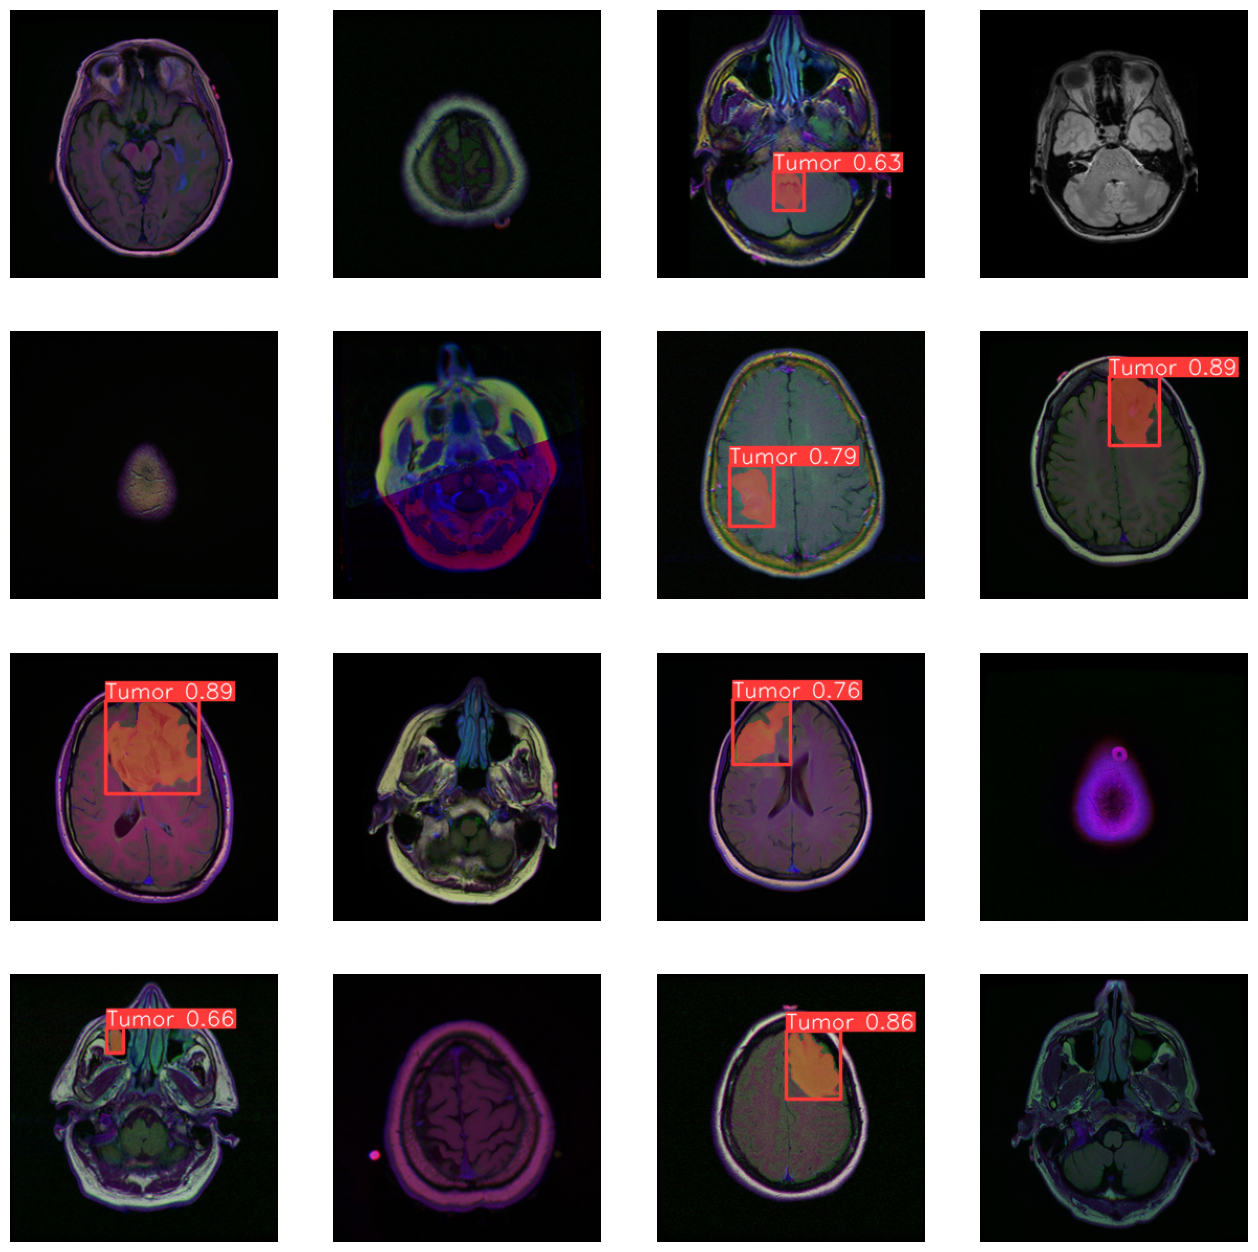

In [22]:
import glob
from PIL import Image
files = glob.glob("/kaggle/working/runs/segment/predict/*")

fig = plt.figure(figsize=(16, 16))
for i in range(1,17, 1):
    fig.add_subplot(4, 4, i)
    img = Image.open(files[i])
    plt.imshow(img)    
    plt.axis(False)
plt.show()

In [32]:
!zip -r runs.zip /kaggle/working/runs

updating: kaggle/working/runs/ (stored 0%)
updating: kaggle/working/runs/segment/ (stored 0%)
updating: kaggle/working/runs/segment/predict2/ (stored 0%)
updating: kaggle/working/runs/segment/predict2/TCGA_FG_A4MT_20020212_47.tif (deflated 1%)
updating: kaggle/working/runs/segment/predict3/ (stored 0%)
updating: kaggle/working/runs/segment/predict3/TCGA_DU_A5TS_19970726_3.tif (deflated 2%)
updating: kaggle/working/runs/segment/predict4/ (stored 0%)
updating: kaggle/working/runs/segment/predict4/TCGA_DU_7010_19860307_25.tif (deflated 2%)
updating: kaggle/working/runs/segment/train/ (stored 0%)
updating: kaggle/working/runs/segment/train/val_batch2_pred.jpg (deflated 22%)
updating: kaggle/working/runs/segment/train/BoxP_curve.png (deflated 18%)
updating: kaggle/working/runs/segment/train/train_batch0.jpg (deflated 8%)
updating: kaggle/working/runs/segment/train/results.csv (deflated 85%)
updating: kaggle/working/runs/segment/train/confusion_matrix.png (deflated 41%)
updating: kaggle/work

## Displays 30 input images, mask images and images randomly predicted by the model in the test set


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_8.tif: 256x256 (no detections), 37.8ms
Speed: 0.8ms preprocess, 37.8ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


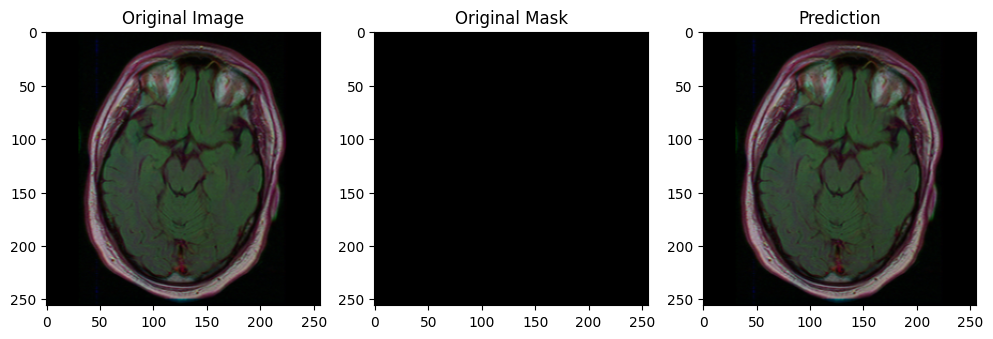


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_11.tif: 256x256 1 Tumor, 35.3ms
Speed: 0.5ms preprocess, 35.3ms inference, 3.2ms postprocess per image at shape (1, 3, 256, 256)


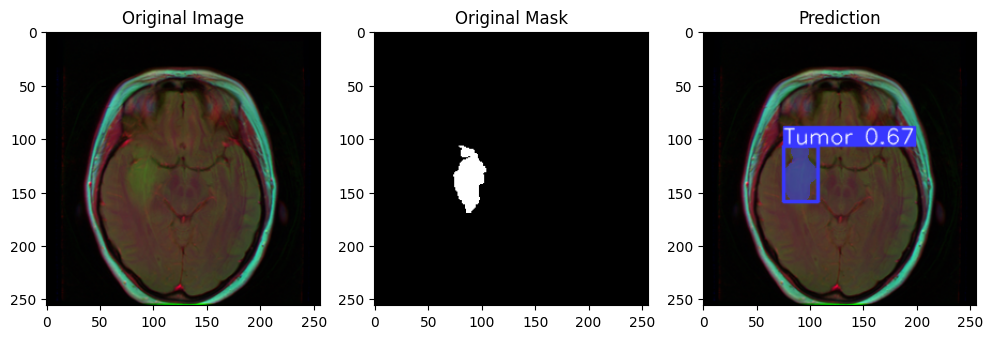


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_50.tif: 256x256 1 Tumor, 35.5ms
Speed: 0.7ms preprocess, 35.5ms inference, 3.1ms postprocess per image at shape (1, 3, 256, 256)


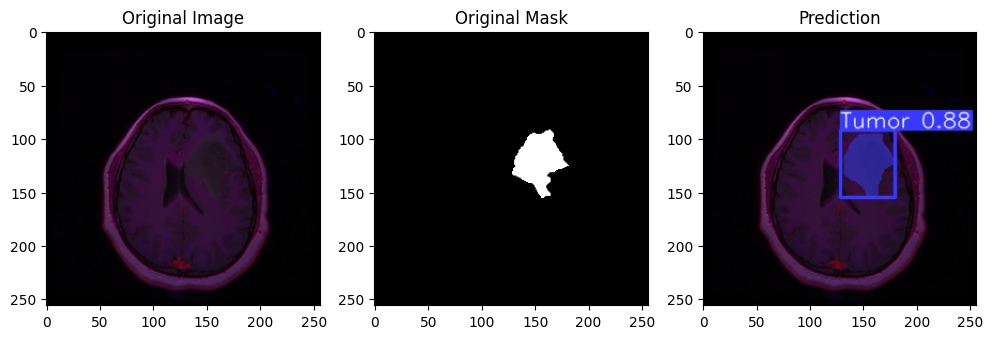


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_65.tif: 256x256 (no detections), 35.4ms
Speed: 0.6ms preprocess, 35.4ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


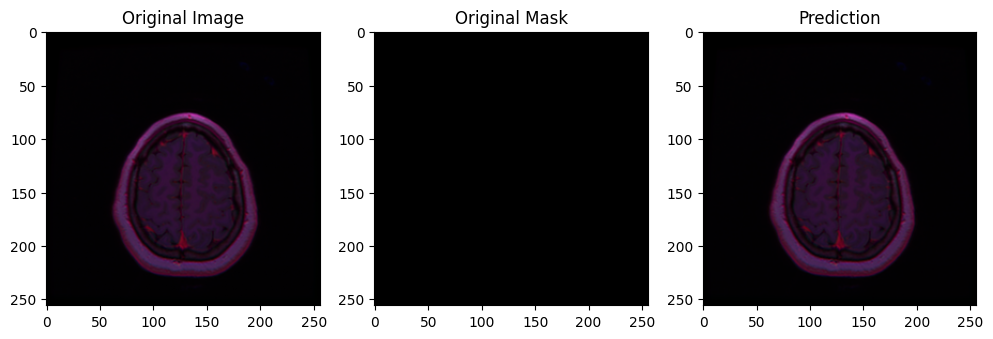


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_11.tif: 256x256 (no detections), 35.3ms
Speed: 0.6ms preprocess, 35.3ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


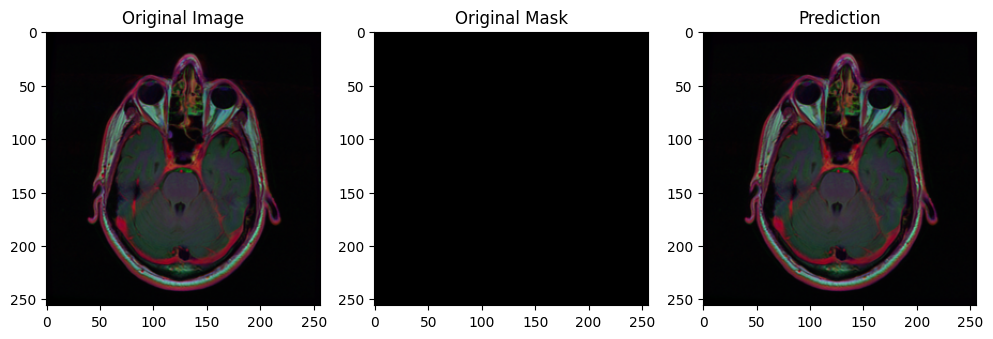


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_9.tif: 256x256 (no detections), 35.4ms
Speed: 0.6ms preprocess, 35.4ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)


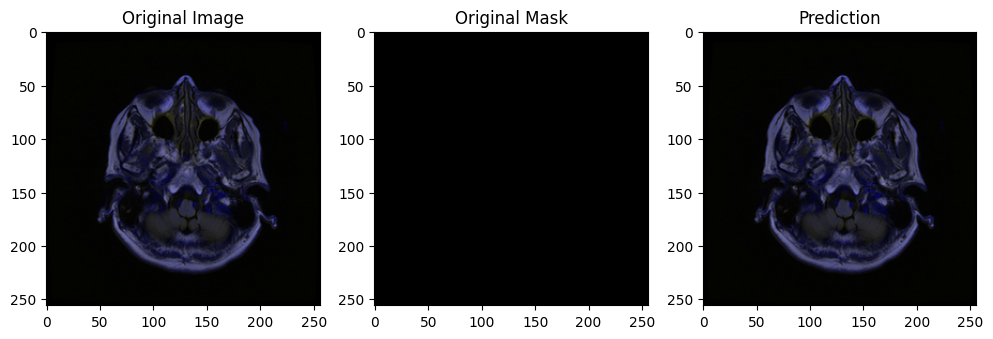


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_34.tif: 256x256 (no detections), 35.4ms
Speed: 0.6ms preprocess, 35.4ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 256)


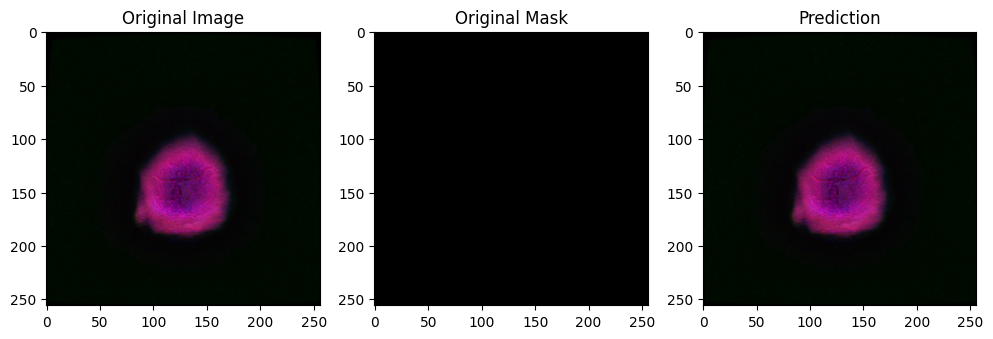


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_12.tif: 256x256 1 Tumor, 35.7ms
Speed: 0.6ms preprocess, 35.7ms inference, 3.2ms postprocess per image at shape (1, 3, 256, 256)


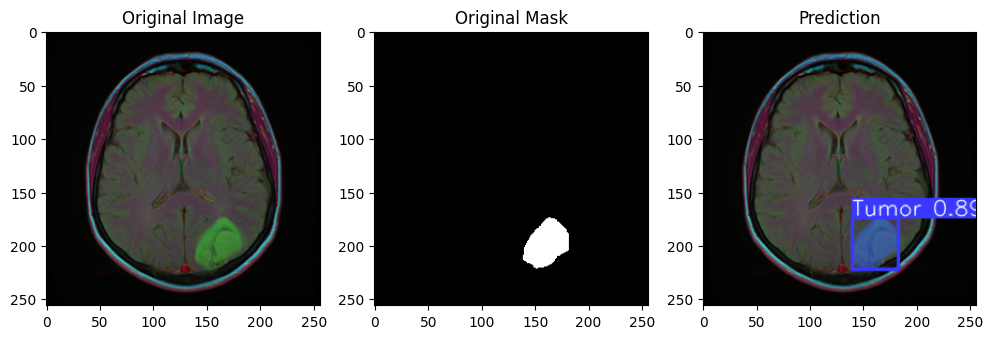


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_32.tif: 256x256 (no detections), 35.3ms
Speed: 0.6ms preprocess, 35.3ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


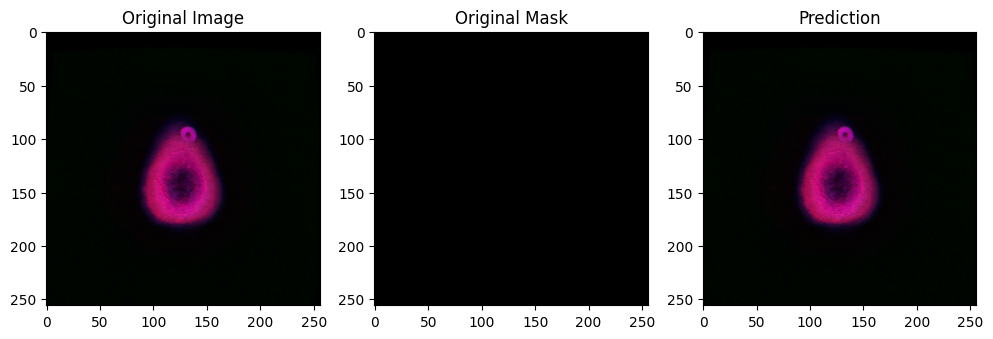


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_16.tif: 256x256 1 Tumor, 35.3ms
Speed: 0.6ms preprocess, 35.3ms inference, 3.2ms postprocess per image at shape (1, 3, 256, 256)


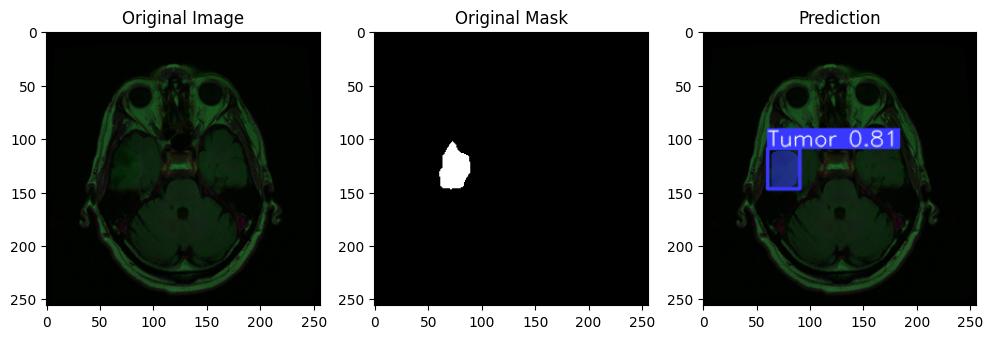


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_34.tif: 256x256 1 Tumor, 35.4ms
Speed: 0.7ms preprocess, 35.4ms inference, 3.0ms postprocess per image at shape (1, 3, 256, 256)


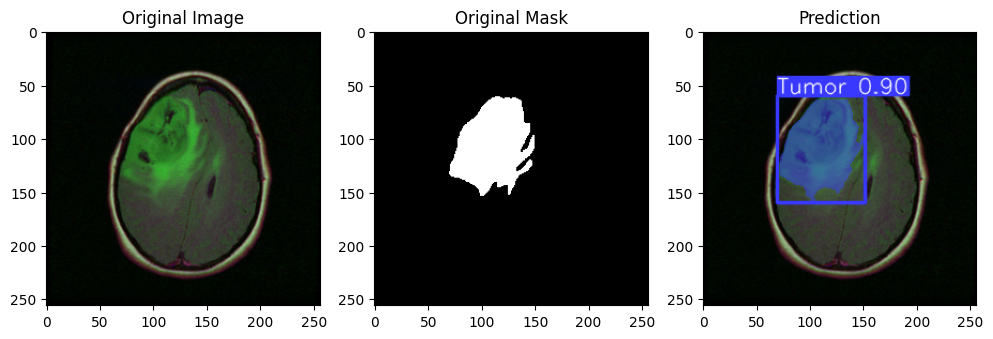


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_16.tif: 256x256 (no detections), 35.6ms
Speed: 0.8ms preprocess, 35.6ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


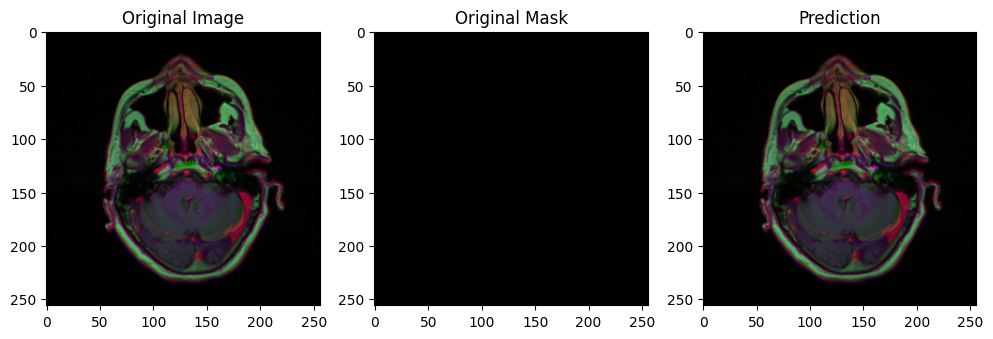


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_14.tif: 256x256 1 Tumor, 35.5ms
Speed: 0.8ms preprocess, 35.5ms inference, 3.1ms postprocess per image at shape (1, 3, 256, 256)


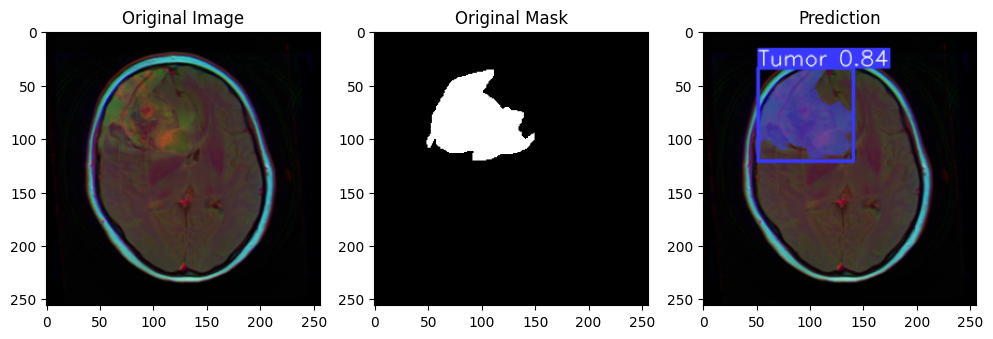


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_19.tif: 256x256 (no detections), 35.5ms
Speed: 0.8ms preprocess, 35.5ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


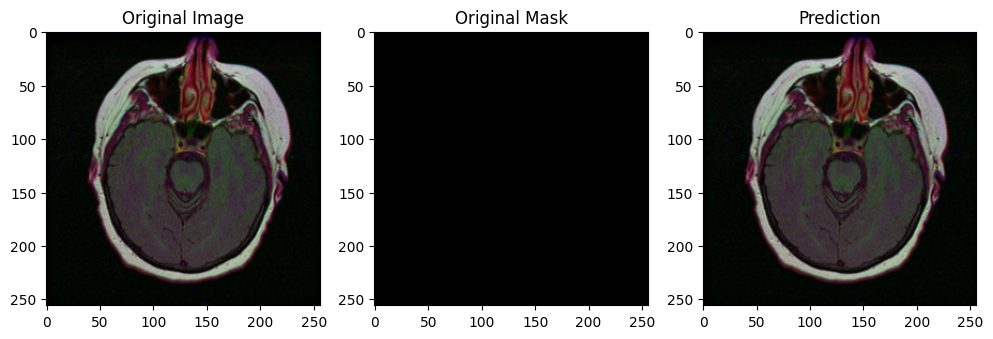


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_26.tif: 256x256 1 Tumor, 35.6ms
Speed: 0.6ms preprocess, 35.6ms inference, 3.2ms postprocess per image at shape (1, 3, 256, 256)


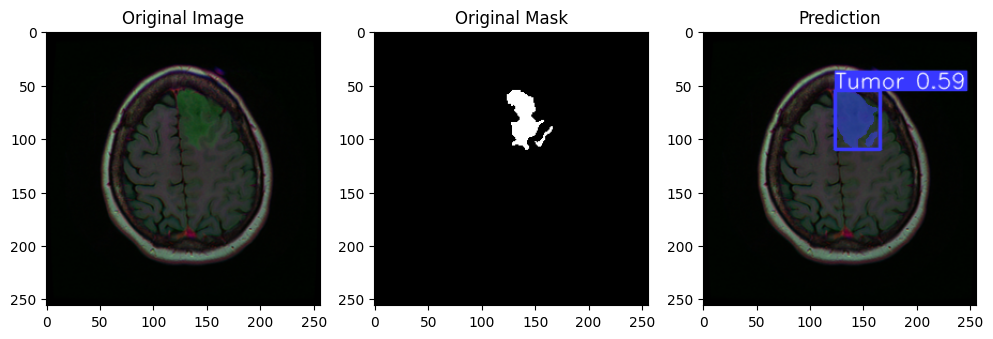


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_19.tif: 256x256 (no detections), 36.1ms
Speed: 0.8ms preprocess, 36.1ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


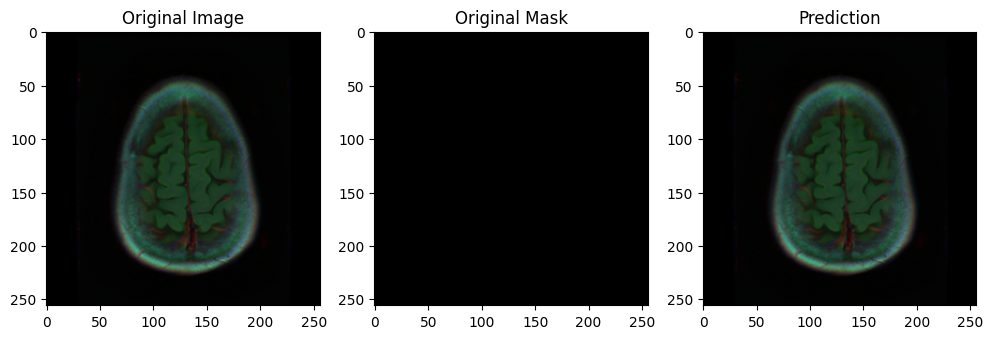


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_34.tif: 256x256 1 Tumor, 35.8ms
Speed: 0.8ms preprocess, 35.8ms inference, 3.1ms postprocess per image at shape (1, 3, 256, 256)


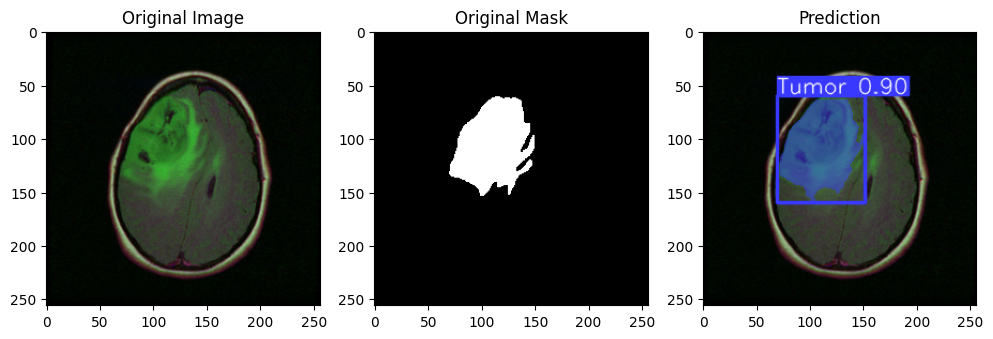


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_5.tif: 256x256 (no detections), 35.9ms
Speed: 0.8ms preprocess, 35.9ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


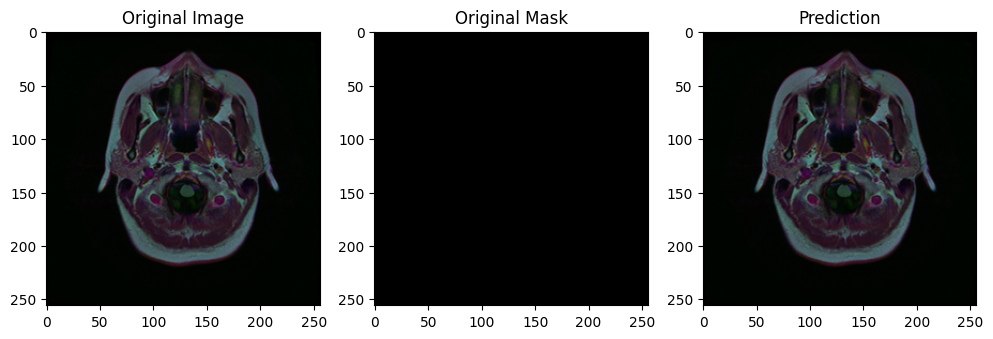


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_14.tif: 256x256 1 Tumor, 36.1ms
Speed: 0.7ms preprocess, 36.1ms inference, 3.0ms postprocess per image at shape (1, 3, 256, 256)


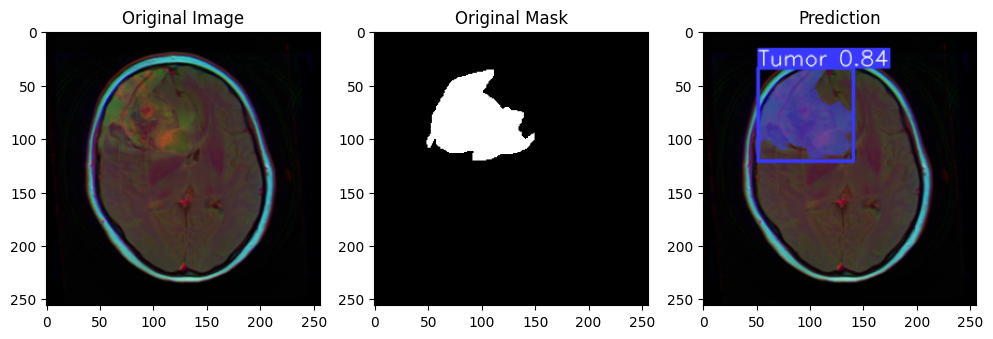


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_38.tif: 256x256 1 Tumor, 35.5ms
Speed: 0.8ms preprocess, 35.5ms inference, 3.1ms postprocess per image at shape (1, 3, 256, 256)


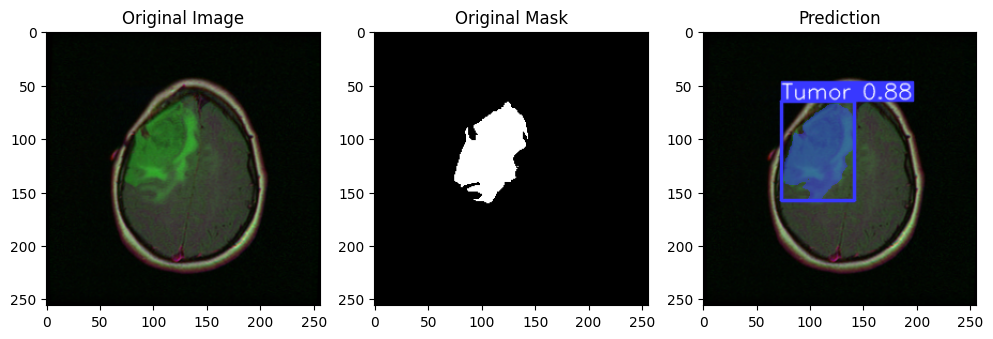


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_8.tif: 256x256 (no detections), 36.9ms
Speed: 0.9ms preprocess, 36.9ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 256)


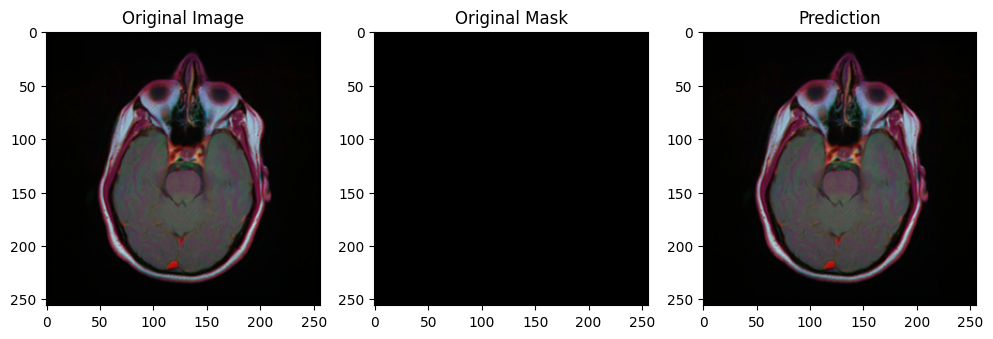


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_56.tif: 256x256 (no detections), 35.4ms
Speed: 0.6ms preprocess, 35.4ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


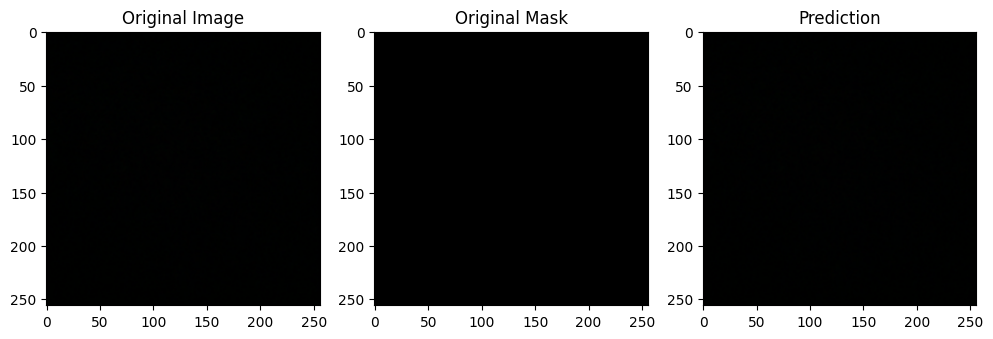


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_4.tif: 256x256 (no detections), 35.4ms
Speed: 0.6ms preprocess, 35.4ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


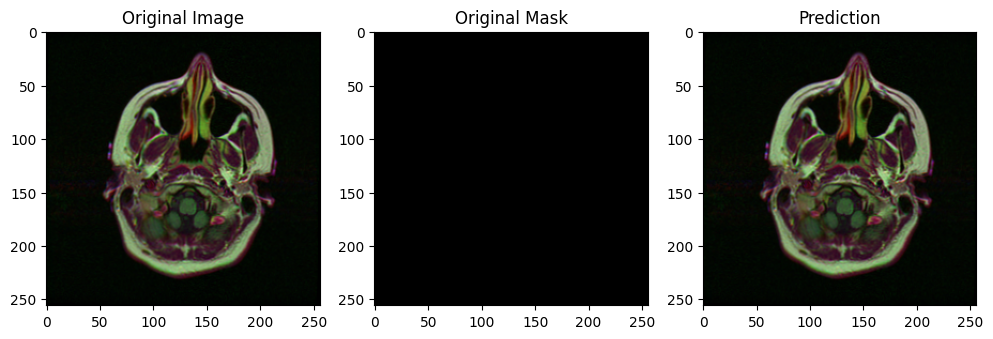


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_29.tif: 256x256 (no detections), 35.4ms
Speed: 0.6ms preprocess, 35.4ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 256)


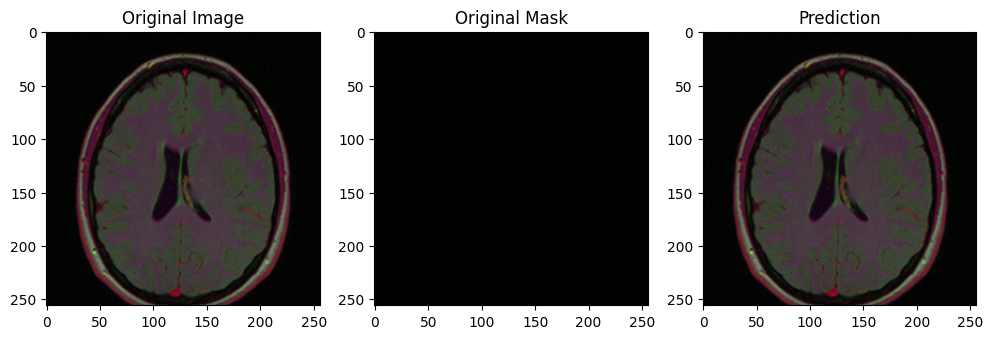


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_12.tif: 256x256 1 Tumor, 35.3ms
Speed: 0.6ms preprocess, 35.3ms inference, 3.1ms postprocess per image at shape (1, 3, 256, 256)


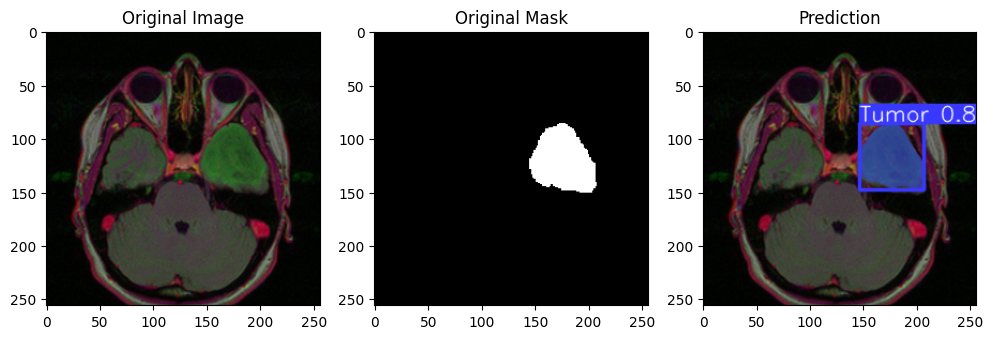


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_15.tif: 256x256 1 Tumor, 36.2ms
Speed: 0.8ms preprocess, 36.2ms inference, 3.2ms postprocess per image at shape (1, 3, 256, 256)


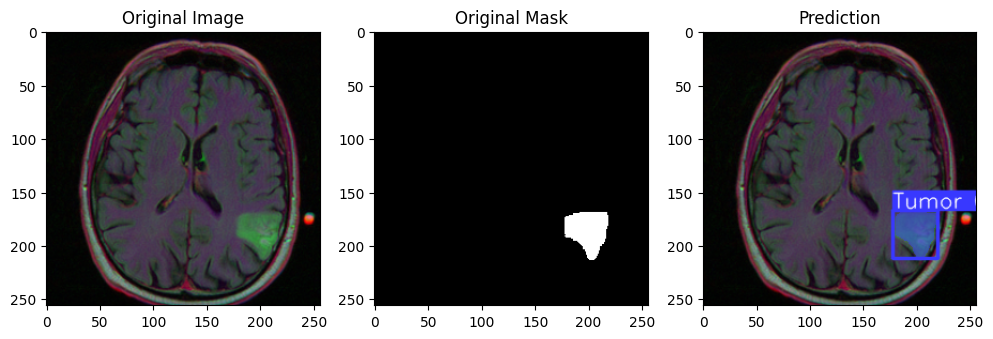


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_20.tif: 256x256 1 Tumor, 36.3ms
Speed: 0.8ms preprocess, 36.3ms inference, 3.1ms postprocess per image at shape (1, 3, 256, 256)


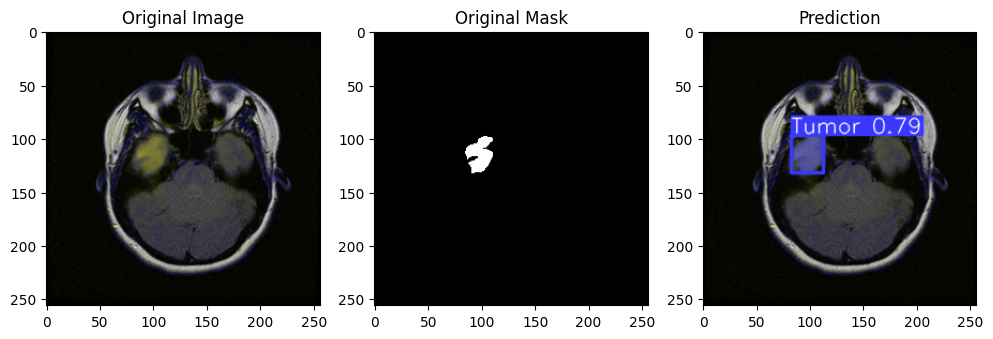


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_17.tif: 256x256 2 Tumors, 35.6ms
Speed: 0.8ms preprocess, 35.6ms inference, 3.1ms postprocess per image at shape (1, 3, 256, 256)


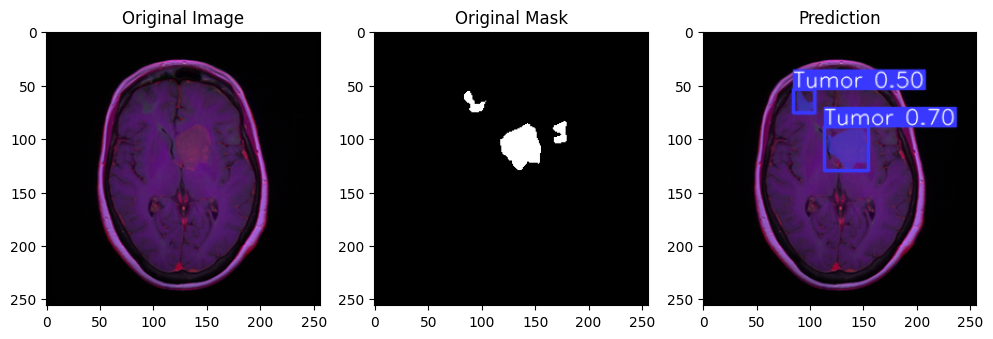


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_20.tif: 256x256 1 Tumor, 35.6ms
Speed: 0.6ms preprocess, 35.6ms inference, 3.1ms postprocess per image at shape (1, 3, 256, 256)


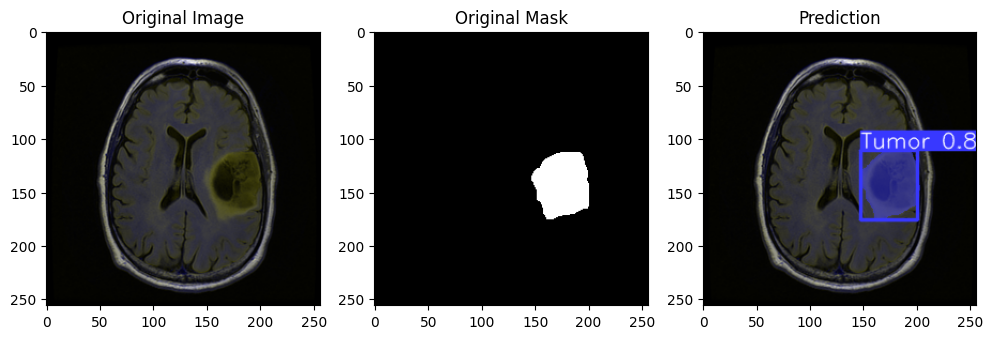


image 1/1 /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_17.tif: 256x256 (no detections), 35.3ms
Speed: 0.6ms preprocess, 35.3ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 256)


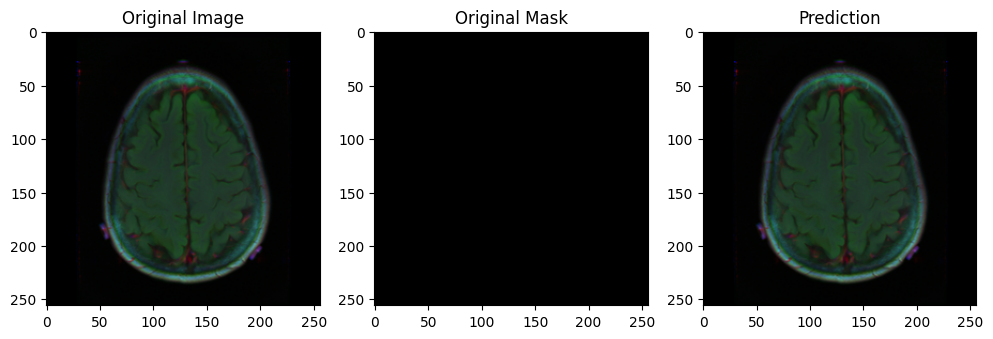

In [26]:
im_height =256
im_width =256
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['image_path'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(df_test['image_path'].iloc[index])
    
    path_im_pred = pred[0].path
    name = path_im_pred.split("/")[6]
    path_im_pred = "/kaggle/working/" + pred[0].save_dir + "/" + name 
    im = cv2.imread(path_im_pred)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask_path'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(im)
    plt.title('Prediction')
    plt.show()